In [20]:
from pathlib import Path
from pandas import Series, DataFrame
from tqdm import tqdm

import imageio
import plotly as plp
import plotly.graph_objs as plgo
import numpy as np
import matplotlib.pyplot as plt
import os.path as op
import cv2
import os
import math
import torch
import torchaudio
import tensorflow as tf

In [2]:
proj_pth = '/work/r08922a13/generative_inpainting'
data_pth = op.join(proj_pth, 'examples/esc50/mag_origin_npy')
os.chdir(proj_pth)

In [ ]:
spec = np.ones([256, 256])
plt.figure()
plt.imshow(spec, 'gray')

In [ ]:
for i, filename in enumerate(sorted(Path(data_pth).glob('*.npy'))):
    print(i, filename)
    
    spec = np.load(filename)
    print(spec.shape)
    h, w, _ = spec.shape
    spec = spec.reshape((h, w))
    print(spec.shape)
    plt.figure()
    plt.imshow(spec, 'gray')
    break

In [ ]:
def l1_loss(x, y):
    error = abs(x - y)
    print(sum(error))
    print(sum(sum(error)))
    return sum(sum(error))

In [ ]:
def psnr(target, ref):
    diff = ref - target
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff ** 2.))
    return 20 * math.log10(1.0 / rmse)

In [ ]:
def create_mask(length, mask_type='square'):
    # For sorted.
    if length < 10:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_00{length}')
    elif length < 100:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_0{length}')
    else:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_{length}')
    
    if op.isfile(output_pth):
        return output_pth
    
    h, w = spec.shape
    mid_point = h // 2, w // 2
    # print(mid_point, length)
    
    mask = np.zeros((h, w, 3), np.uint8)
    if mask_type == 'square':
        t = mid_point[0] - (length // 2) + 1
        b = mid_point[0] + (length // 2)
        l = mid_point[1] - (length // 2) + 1
        r = mid_point[1] + (length // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)
    elif mask_type == 'time':
        area = length * length
        if area < h * 1:
            constant = 11
            height = area // constant
            t = mid_point[0] - (height // 2) + 1
            b = mid_point[0] + (height // 2)
            l = mid_point[1] - (constant // 2) + 1
            r = mid_point[1] + (constant // 2)
        else:
            width = area // h
            t = 0 + 1
            b = h
            l = mid_point[1] - (width // 2) + 1
            r = mid_point[1] + (width // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # print(gray[110][:])

    plt.figure()
    plt.imshow(mask, 'gray')
    # print(mask[0])

    # This way is for showing the visualized results then convert to 1-channel.
    mask = mask[:, :, np.newaxis]
    # print(square_mask.shape)

    np.save(output_pth, mask)
    return output_pth + '.npy'

In [ ]:
def create_mask_base_on_time(length, mask_type='square'):
    # For sorted.
    if length < 10:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_00{length}')
    elif length < 100:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_0{length}')
    else:
        output_pth = op.join(proj_pth, f'examples/esc50/mask_256/mask_{mask_type}_{length}')
    
    if op.isfile(output_pth):
        return output_pth
    
    h, w = spec.shape
    mid_point = h // 2, w // 2
    # print(mid_point, length)
    
    mask = np.zeros((h, w, 3), np.uint8)
    if mask_type == 'square':
        area = h * length
        side = math.floor(math.sqrt(area))
        t = mid_point[0] - (side // 2) + 1
        b = mid_point[0] + (side // 2)
        l = mid_point[1] - (side // 2) + 1
        r = mid_point[1] + (side // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)
    elif mask_type == 'time':
        width = length
        t = 0 + 1
        b = h
        l = mid_point[1] - (width // 2) + 1
        r = mid_point[1] + (width // 2)
        # print(t, b, l, r)
        mask = cv2.rectangle(mask, (l, t), (r, b), (255, 255, 255), -1)

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # print(gray[110][:])

    plt.figure()
    plt.imshow(mask, 'gray')
    # print(mask[0])

    # This way is for showing the visualized results then convert to 1-channel.
    mask = mask[:, :, np.newaxis]
    # print(square_mask.shape)

    np.save(output_pth, mask)
    return output_pth + '.npy'

In [ ]:
output_pth = op.join(proj_pth, 'examples/esc50/mag_origin_npy/loss_test_output')
loss_pth = op.join(output_pth, 'l1_loss')
checkpoint = op.join(proj_pth, 'logs/full_model_esc50_origin_npy_test')
square_l1_loss = []
# Set 10 as progress unix for mask length. From 10 -> 400.
for i in range(64):
    image = filename
    
    mask_type = 'square'
    mask_length = (i + 1) * 4
    mask = create_mask_base_on_time(mask_length, mask_type)
    
    #print(op.basename(filename))
    #output_filename = op.basename(filename).split('.')[0] + f'_{mask_type}_{i}' + '.' + op.basename(filename).split('.')[1]
    #output = op.join(output_pth, output_filename)
    #print(output)
    '''
    cmd = f'python /work/r08922a13/generative_inpainting/test.py --image {image} --mask {mask} --output {output} --checkpoint {checkpoint}'
    print(cmd)
    os.system(cmd)
    
    inpaint_spec = np.load(output)
    h, w, _ = inpaint_spec.shape
    inpaint_spec = inpaint_spec.reshape((h, w))

    square_l1_loss.append(l1_loss(spec, inpaint_spec))
    #break
    
loss_filename = op.join(loss_pth, f'l1_loss_{mask_type}.txt')
with open(loss_filename, 'w') as f:
    for index in square_l1_loss:
        f.write(str(index)+'\n')
    '''

In [ ]:
output = '/work/r08922a13/generative_inpainting/examples/esc50/mag_origin_npy/loss_test_output/1-80841-A-13_spec_square_22.npy'
inpaint_spec = np.load(output)
h, w, _ = inpaint_spec.shape
inpaint_spec = inpaint_spec.reshape((h, w))

In [ ]:
loss = psnr(spec, inpaint_spec)
print(loss)

In [ ]:
mask_type = 'square'
loss_filename = op.join(output_pth, f'l1_loss_{mask_type}.txt')
with open(loss_filename, 'r') as f:
    sq_loss_list = f.read().splitlines()
print(sq_loss_list)
square_l1 = [float(i) for i in sq_loss_list]

mask_type = 'time'
loss_filename = op.join(output_pth, f'l1_loss_{mask_type}.txt')
with open(loss_filename, 'r') as f:
    time_loss_list = f.read().splitlines()
print(time_loss_list)
time_l1 = [float(i) for i in time_loss_list]

In [ ]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/loss'
loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

In [ ]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_within/loss'
within_loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        within_loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

In [ ]:
loss_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_time_mask_only/loss'
only_loss_trace_list = []
for filename in sorted(Path(loss_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    loss_type = op.basename(filename).split('.')[0].split('_')[2]
    mask_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, loss_type, mask_type)
    with open(filename, 'r') as f:
        loss_list = f.read().splitlines()
        loss_list_float = [float(i) for i in loss_list]
        only_loss_trace_list.append([loss_list_float, sound_name, loss_type, mask_type])

In [43]:
err_pth = '/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss'
err_trace_list = []
for filename in sorted(Path(err_pth).glob('*.txt')):
    print(filename)
    sound_name = op.basename(filename).split('.')[0].split('_')[0]
    mask_type = op.basename(filename).split('.')[0].split('_')[-2]
    error_type = op.basename(filename).split('.')[0].split('_')[-1]
    print(sound_name, error_type, mask_type)
    with open(filename, 'r') as f:
        err_list = f.read().splitlines()
        err_list_float = [float(i) for i in err_list]
        err_trace_list.append([err_list_float, sound_name, error_type, mask_type])

/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss/1-46353-A-49_2_square_error.txt
1-46353-A-49 error square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss/1-46353-A-49_2_square_mean-l1.txt
1-46353-A-49 mean-l1 square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss/1-46353-A-49_2_time_error.txt
1-46353-A-49 error time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss/1-46353-A-49_2_time_mean-l1.txt
1-46353-A-49 mean-l1 time
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss/4-181628-A-17_3_square_error.txt
4-181628-A-17 error square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_test_output/audio/loss/4-181628-A-17_3_square_mean-l1.txt
4-181628-A-17 mean-l1 square
/work/r08922a13/generative_inpainting/examples/esc50/mag_seg15_256/loss_te

In [30]:
area_list = []
for i in range(64):
    length = (i+1) * 4
    area_list.append(length)
print(area_list)
area_list = np.array(area_list)

[4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256]


In [ ]:
square_l1_np = np.array(square_l1)
square_l1_around = np.around(square_l1_np, decimals=1)
print(square_l1_around)
square_l1_1f = ["{:0.1f}".format(v) for v in square_l1_around]
print(square_l1_1f)

time_l1_np = np.array(time_l1)
time_l1_around = np.around(time_l1_np, decimals=1)
print(time_l1_around)
time_l1_1f = ["{:0.1f}".format(v) for v in time_l1_around]
print(time_l1_1f)

In [48]:
loss_trace_list = err_trace_list # Enable if testing the error on waveform
set_num = 0
trace01, name01, loss01, mask01 = loss_trace_list[set_num * 4 + 1]
trace02, name02, loss02, mask02 = loss_trace_list[set_num * 4 + 3]
if loss01 == 'mean': loss01 = 'mean L1'
print(trace01, name01, loss01, mask01)
print(trace02, name02, loss02, mask02)
trace_1 = plgo.Scatter(x=area_list, y=trace01, mode='markers', name=mask01)
trace_2 = plgo.Scatter(x=area_list, y=trace02, mode='markers', name=mask02)
data = [trace_1, trace_2]
layout = plgo.Layout(
    xaxis={'title':f'length ({name01})', 'titlefont':{'size':15}},
    yaxis={'title':f'loss ({loss01})', 'titlefont':{'size':15}})
fig = plgo.Figure(data=data, layout=layout)
plp.offline.iplot(fig, filename=loss01)

[0.03931974992156029, 0.038770973682403564, 0.039201848208904266, 0.040126048028469086, 0.03955765441060066, 0.03998689725995064, 0.03893120214343071, 0.03899432346224785, 0.03996092826128006, 0.039743974804878235, 0.039220694452524185, 0.03839651495218277, 0.03942262381315231, 0.040149230509996414, 0.039381030946969986, 0.03955677151679993, 0.03920663148164749, 0.03988007828593254, 0.03976445645093918, 0.03832480311393738, 0.03862868994474411, 0.04032246768474579, 0.03899798169732094, 0.03908050060272217, 0.039246752858161926, 0.03719029948115349, 0.03949020430445671, 0.03806313872337341, 0.03787123039364815, 0.03940356522798538, 0.039266157895326614, 0.03862748295068741, 0.038920238614082336, 0.038965173065662384, 0.03823268786072731, 0.03870485723018646, 0.03908433020114899, 0.03878637030720711, 0.03921833634376526, 0.03910844027996063, 0.03900666534900665, 0.037985872477293015, 0.03814597427845001, 0.037623561918735504, 0.03575900197029114, 0.03603116422891617, 0.036009326577186584

In [ ]:
set_num = 10
constant = 0 # time = 1, square = 0
trace01, name01, loss01, mask01 = loss_trace_list[set_num * 2 + constant]
trace02, name02, loss02, mask02 = within_loss_trace_list[set_num * 2 + constant]
trace03, name03, loss03, mask03 = only_loss_trace_list[set_num * 2 + constant]
if loss01 == 'mean': loss01 = 'mean L1'
print(trace01, name01, loss01, mask01)
print(trace02, name02, loss02, mask02)
print(trace03, name03, loss03, mask03)
trace_1 = plgo.Scatter(x=area_list, y=trace01, mode='markers', name='rect')
trace_2 = plgo.Scatter(x=area_list, y=trace02, mode='markers', name='within')
trace_3 = plgo.Scatter(x=area_list, y=trace03, mode='markers', name='time')
data = [trace_1, trace_2, trace_3]
layout = plgo.Layout(
    xaxis={'title':f'length ({name01})', 'titlefont':{'size':15}},
    yaxis={'title':f'loss ({loss01})', 'titlefont':{'size':15}})
fig = plgo.Figure(data=data, layout=layout)
plp.offline.iplot(fig, filename=loss01)

In [ ]:
trace_0 = plgo.Scatter(x=area_list, y=square_l1_1f, mode='markers', name='square mask')
trace_1 = plgo.Scatter(x=area_list, y=time_l1_1f, mode='markers', name='time mask')
data = [trace_0, trace_1]
layout = plgo.Layout(
    xaxis={'title':'length', 'titlefont':{'size':20}},
    yaxis={'title':'loss (l1)', 'titlefont':{'size':20}})
fig = plgo.Figure(data=data, layout=layout)
plp.offline.iplot(fig, filename='loss')

In [ ]:
data = np.stack((area_list, time_l1_1f))
print(data, data.shape)

plt.figure()
plt.ylabel('l1loss')
plt.xlabel('length')
plt.plot(area_list, time_l1_1f, 'k', linestyle='dashed', marker='o')

In [ ]:
data_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/')
png_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_time_mask_only/diff_output/png')
shape = ['square', 'time']
for filename in sorted(Path(data_pth).glob('*.npy')):
    #print(filename)
    file = op.basename(filename).split('.')[0]
    for anyshape in shape:
        #print(file, anyshape)
        file_shape = file + '_' + anyshape
        print(file_shape)
        with imageio.get_writer(op.join(png_pth, f'{file_shape}.gif'), mode='I', duration=0.2) as writer:
            for png in tqdm(sorted(Path(png_pth).glob(f'{file_shape}*.png'))):
                # print(png)
                image = imageio.imread(png)
                #plt.figure()
                #plt.imshow(image, 'gray')
                writer.append_data(image)
'''
mask_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_output/png')
with imageio.get_writer(op.join(mask_pth, '../mask_square.gif'), mode='I', duration=0.2) as writer:
    for png in sorted(Path(mask_pth).glob('mask_square*')):
        print(png)
        image = imageio.imread(png)
        #plt.figure()
        #plt.imshow(image, 'gray')
        writer.append_data(image)
'''

In [ ]:
data_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/')
output_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_time_mask_only')
diff_pth = op.join(output_pth, 'diff_output')
shape = ['square', 'time']
for filename in sorted(Path(data_pth).glob('*.npy')):
    origin = np.load(filename)
    file = op.basename(filename).split('.')[0]
    for anyshape in shape:
        file_shape = file + '_' + anyshape
        for output in tqdm(sorted(Path(output_pth).glob(f'{file_shape}*.npy'))):
            #print(output)
            inpainted = np.load(output)
            diff = abs(inpainted - origin)
            diff_output = op.join(diff_pth, op.basename(output))
            #print(diff_output)
            np.save(diff_output, diff)

 31%|███▏      | 20/64 [00:03<00:06,  6.52it/s]/home/r08922a13/.conda/envs/deepfill/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

100%|██████████| 64/64 [00:13<00:00,  4.74it/s]


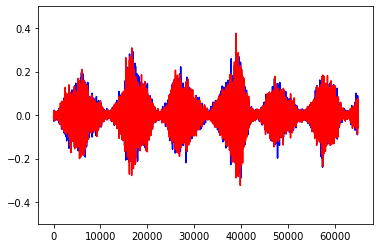

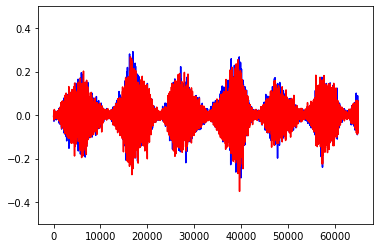

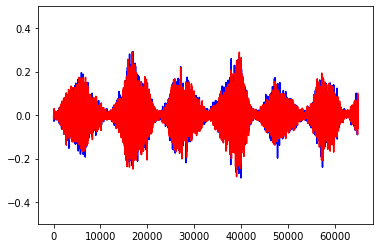

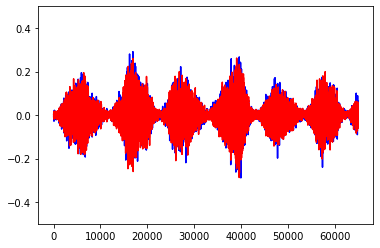

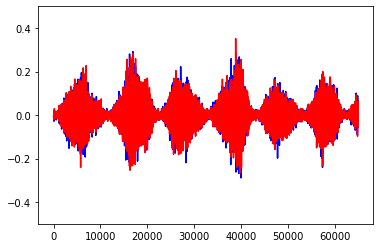

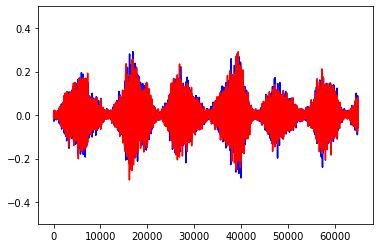

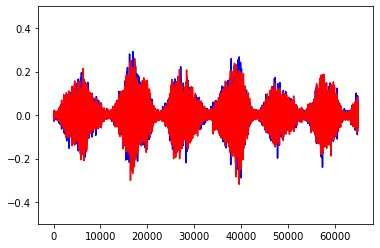

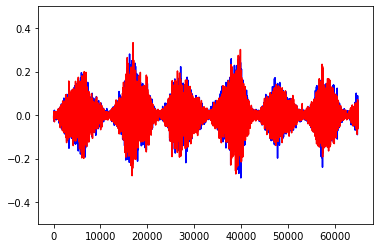

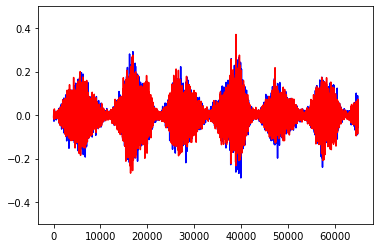

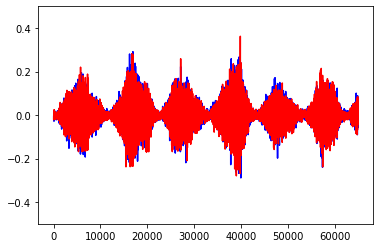

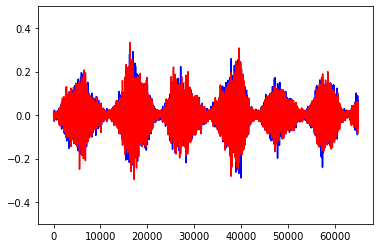

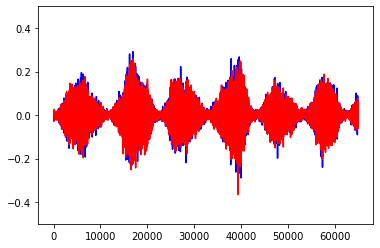

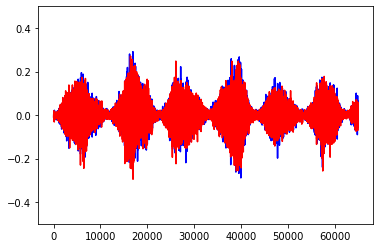

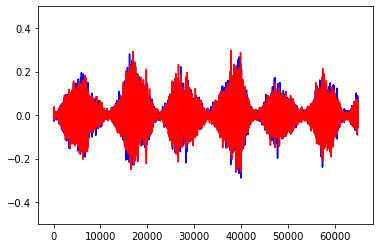

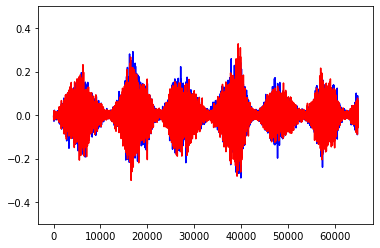

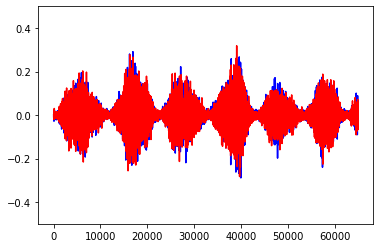

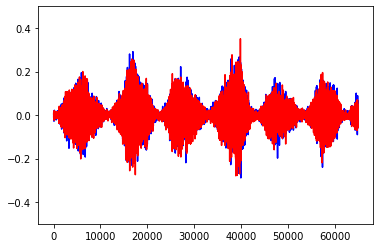

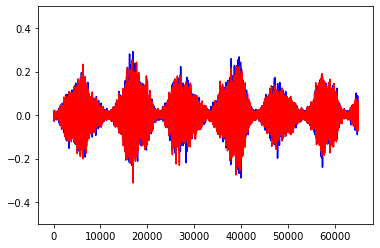

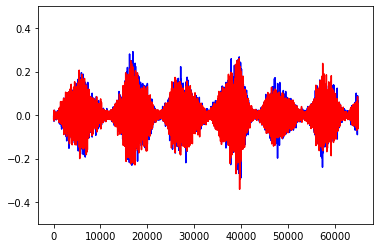

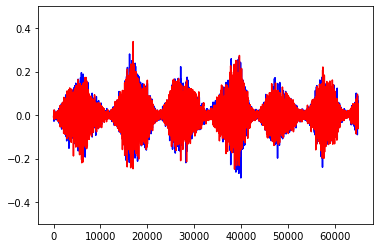

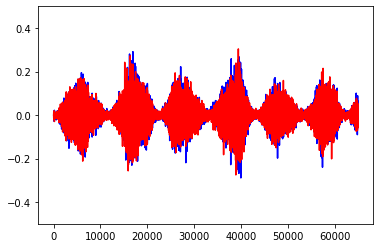

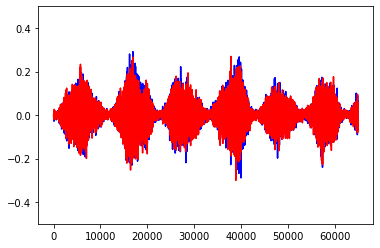

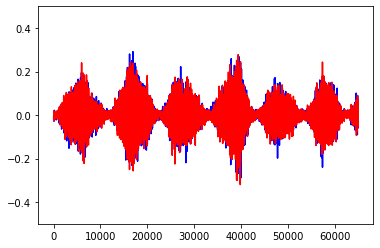

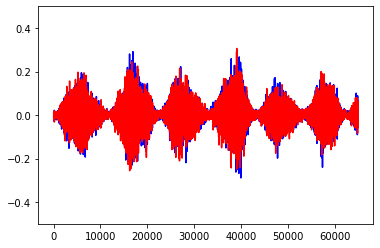

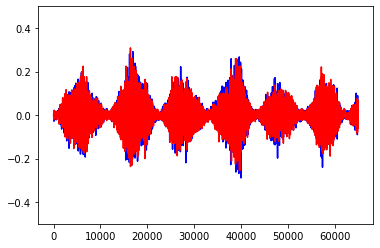

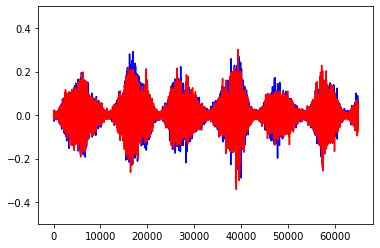

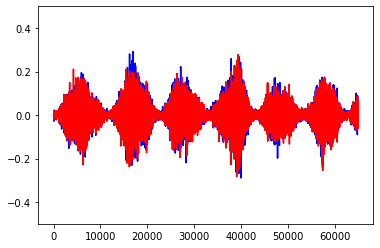

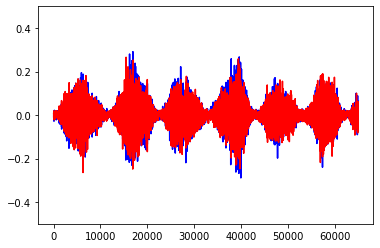

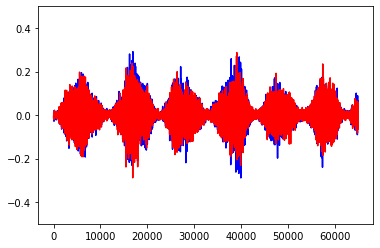

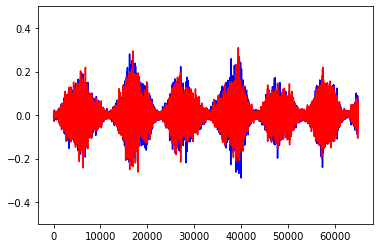

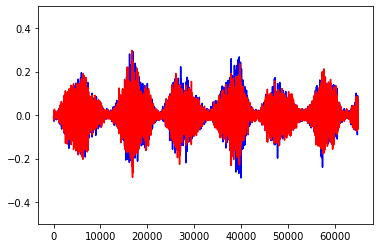

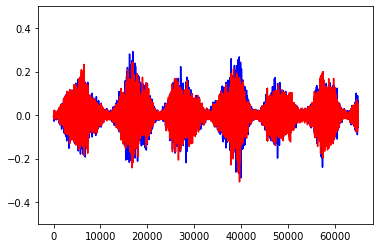

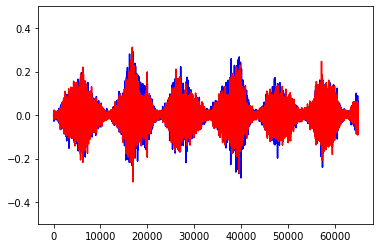

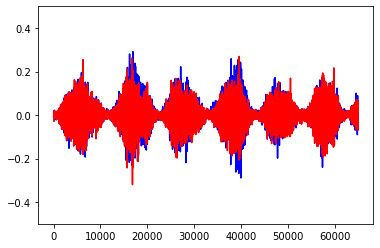

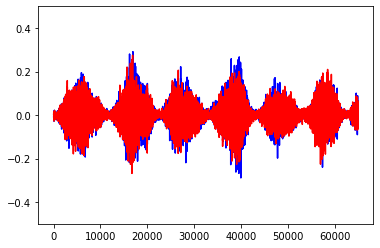

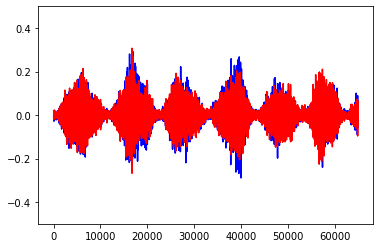

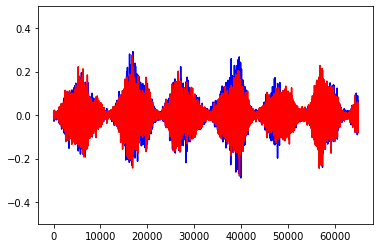

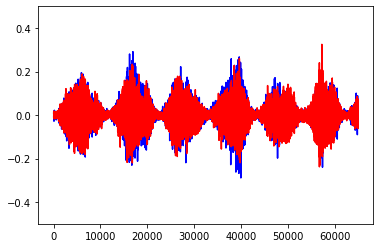

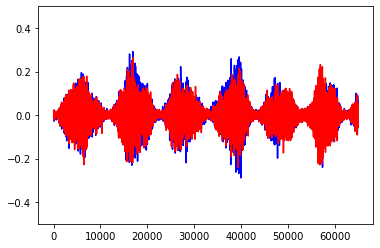

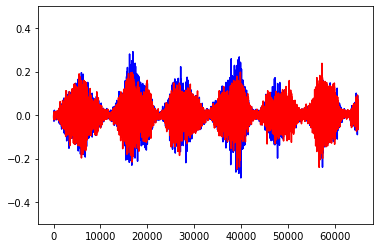

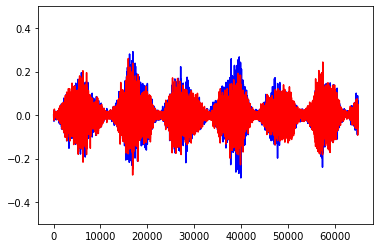

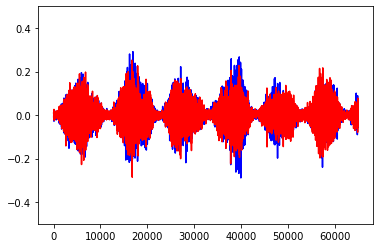

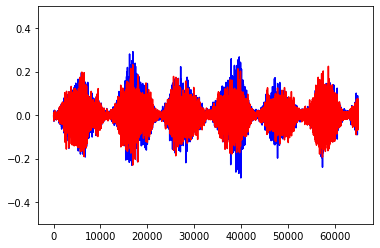

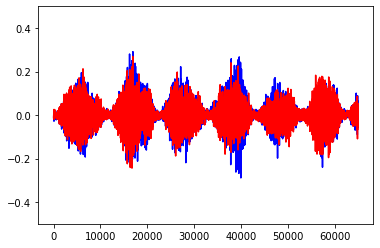

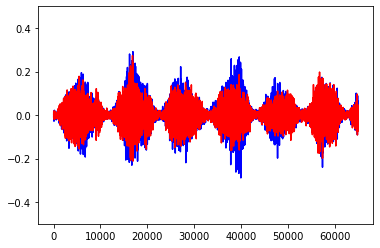

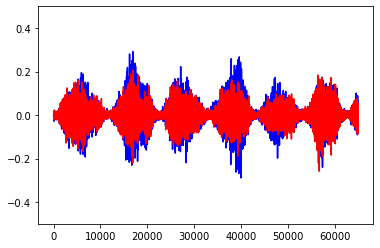

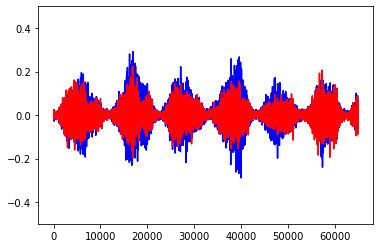

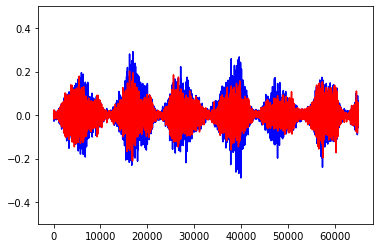

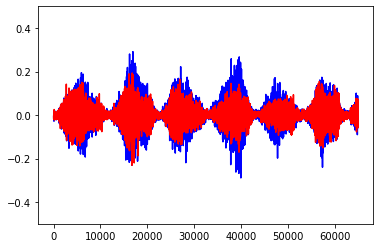

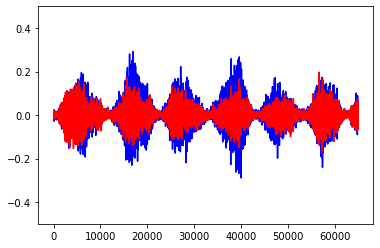

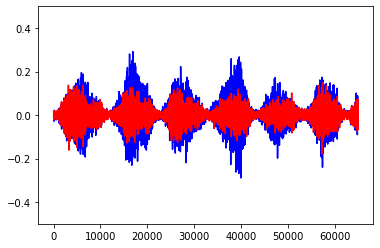

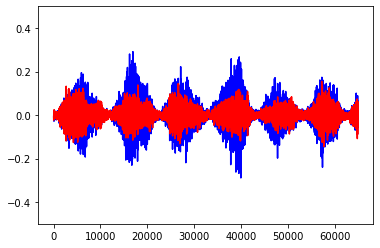

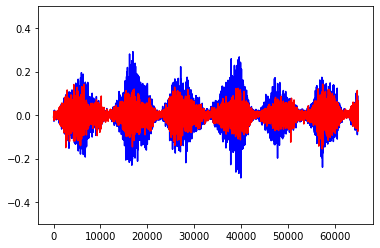

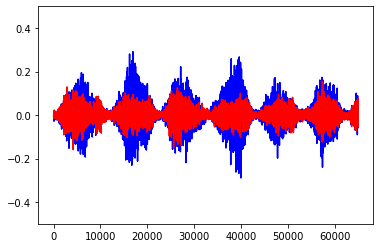

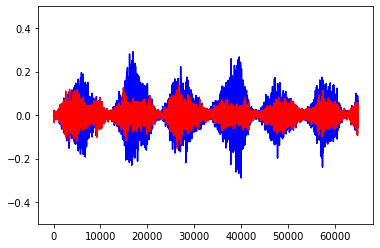

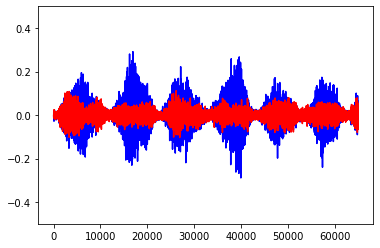

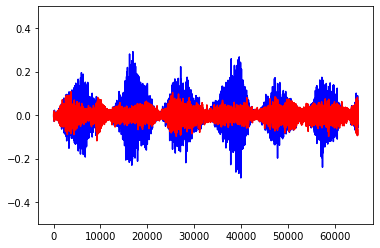

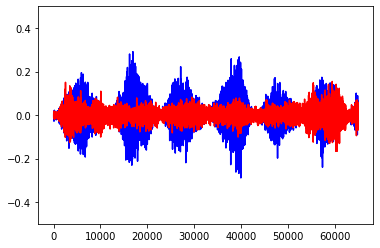

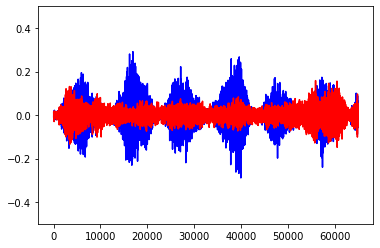

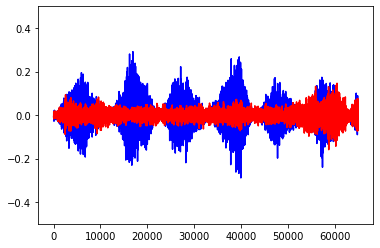

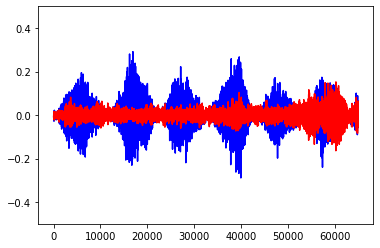

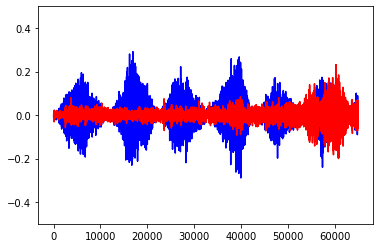

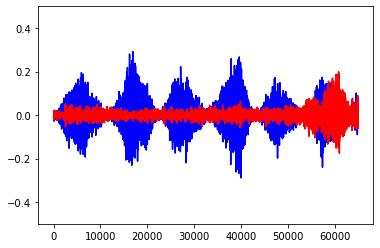

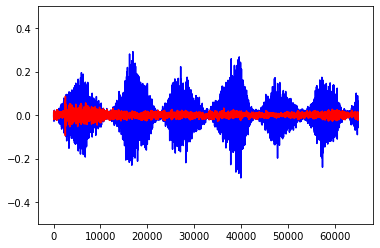

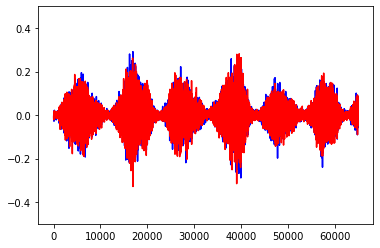

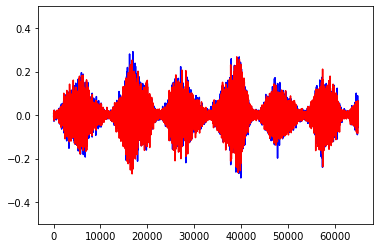

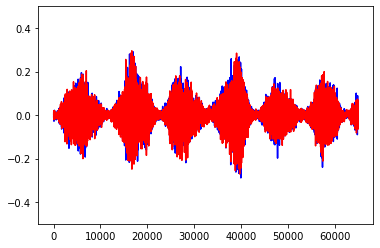

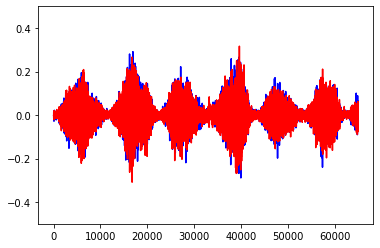

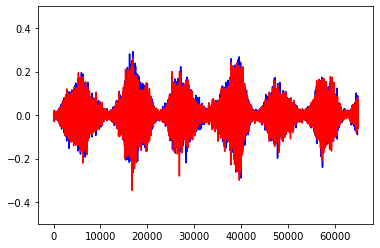

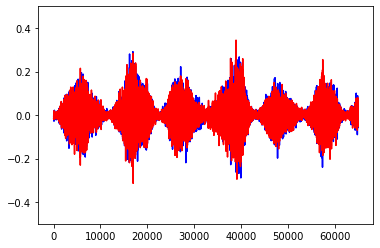

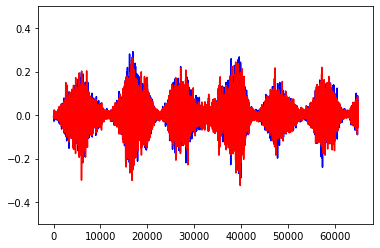

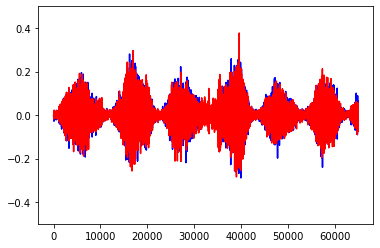

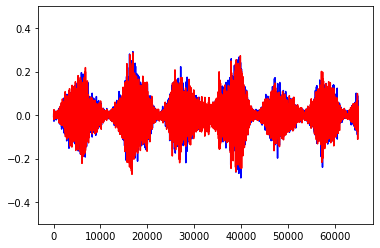

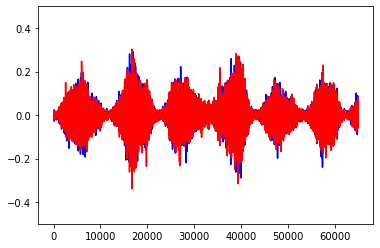

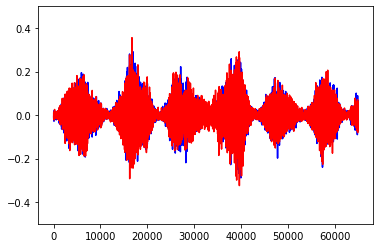

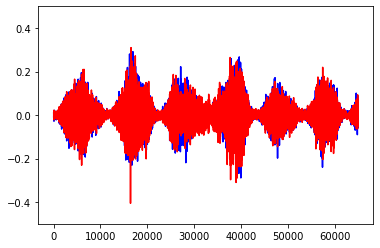

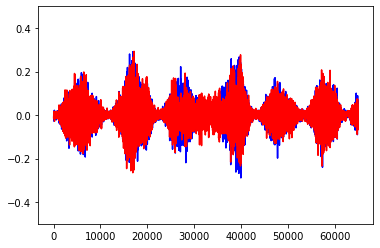

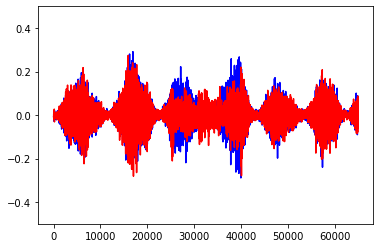

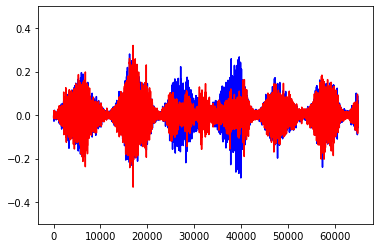

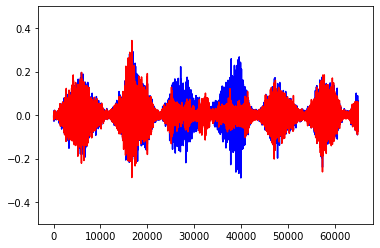

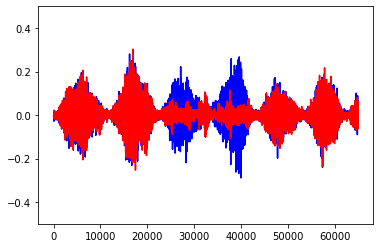

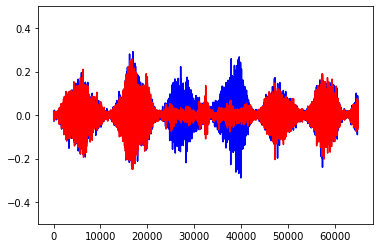

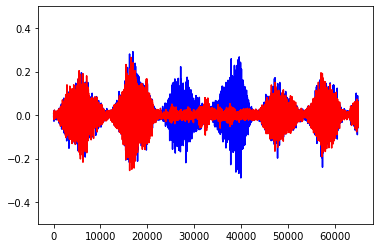

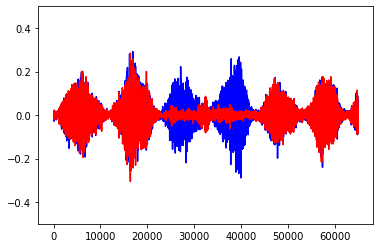

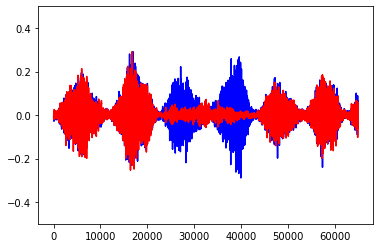

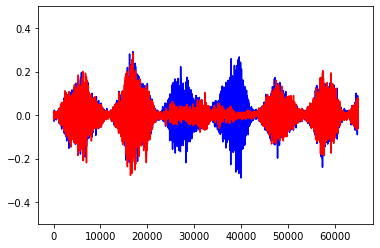

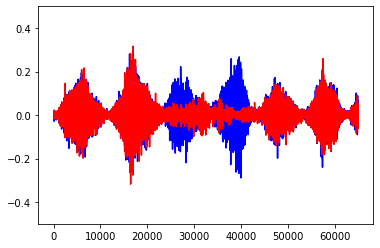

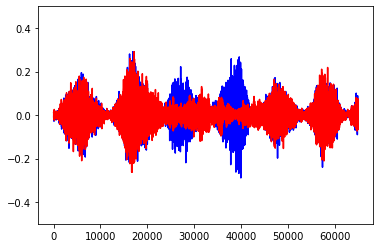

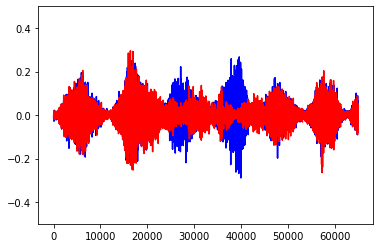

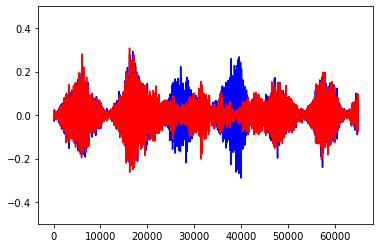

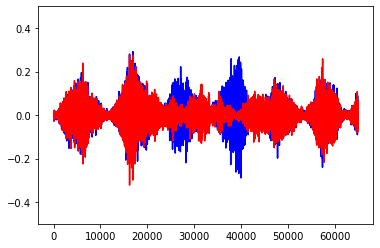

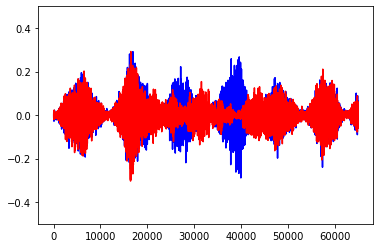

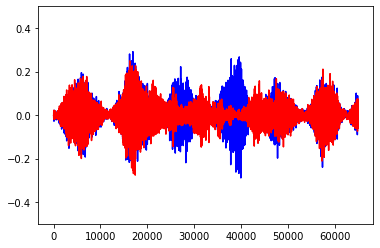

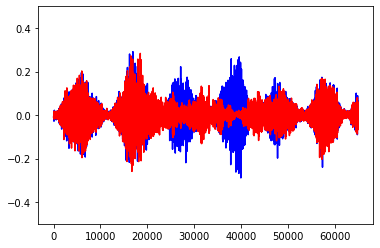

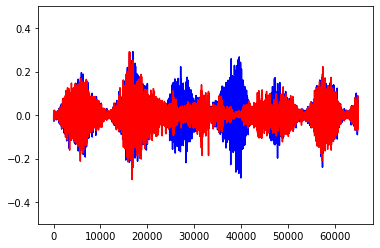

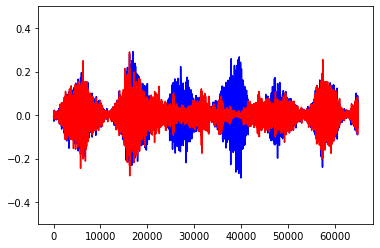

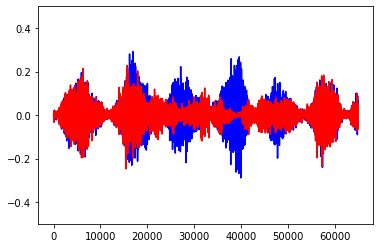

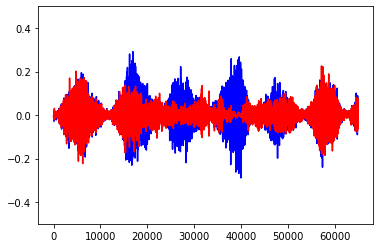

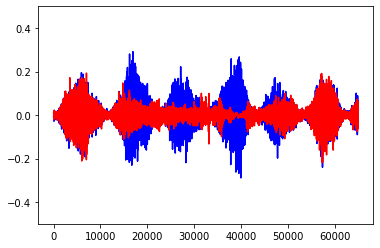

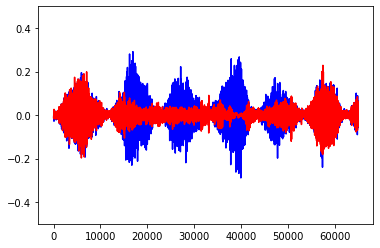

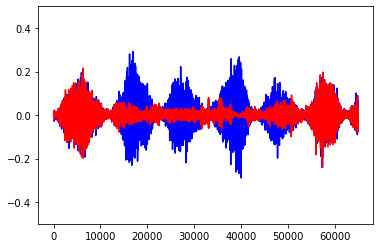

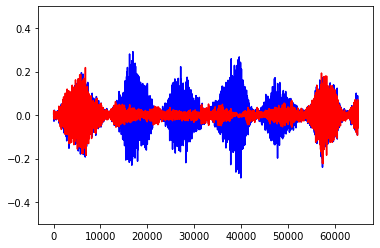

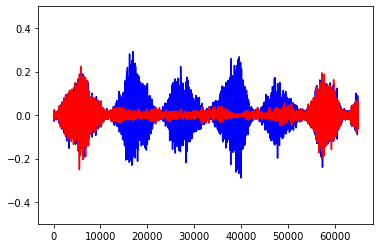

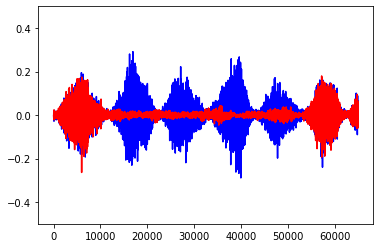

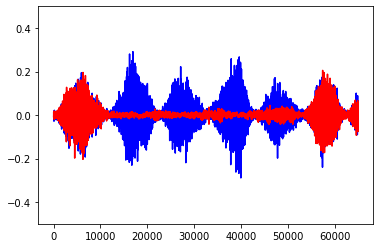

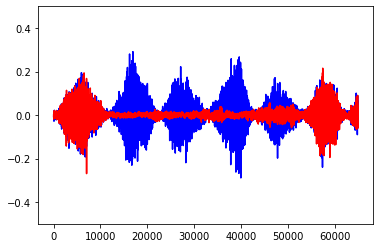

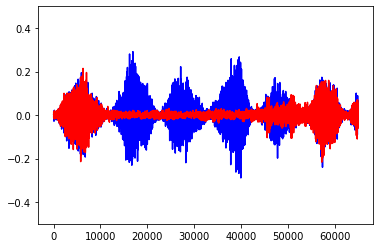

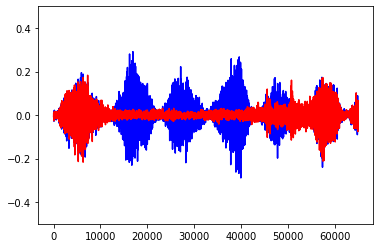

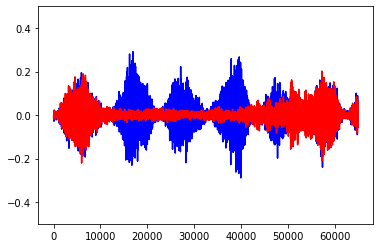

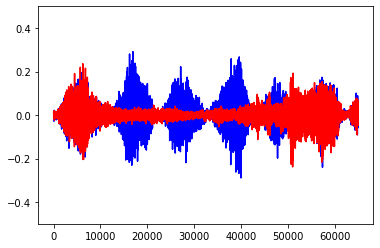

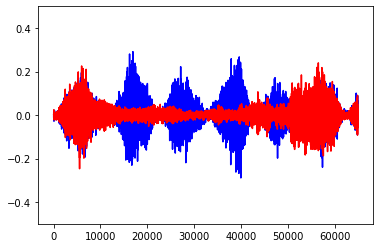

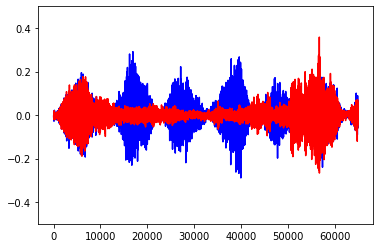

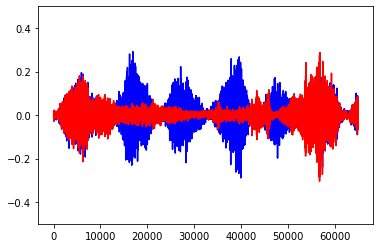

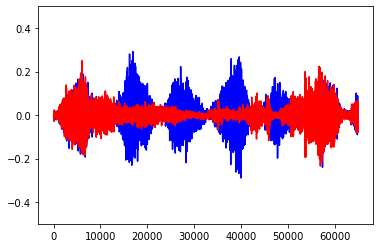

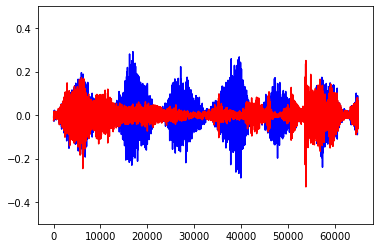

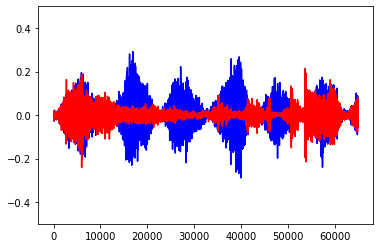

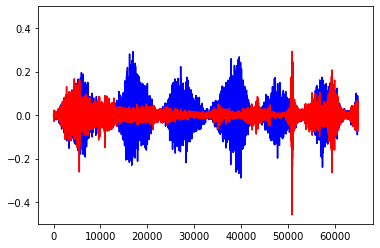

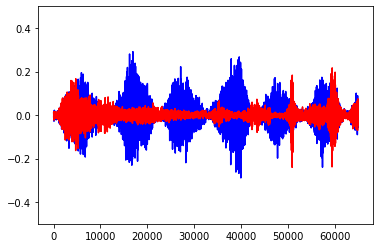

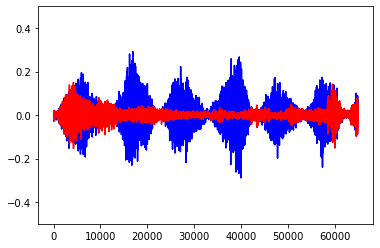

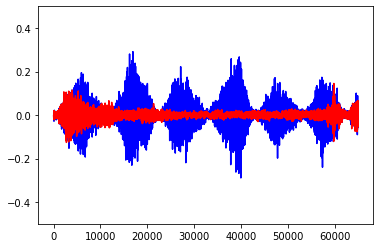

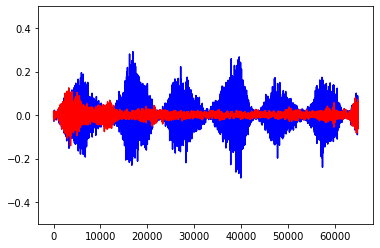

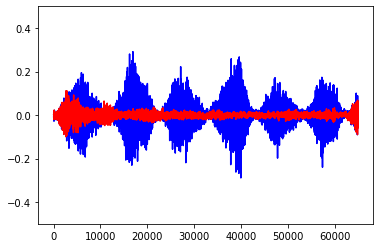

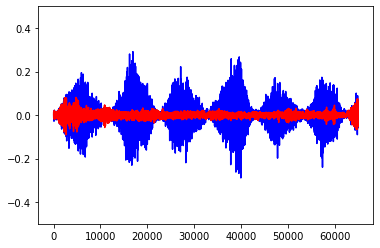

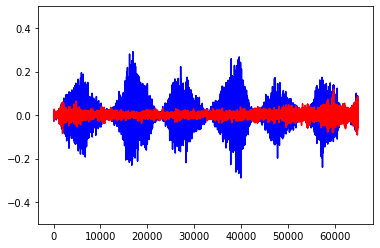

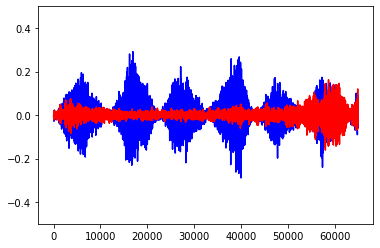

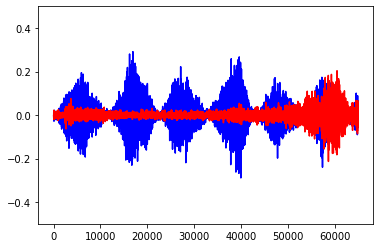

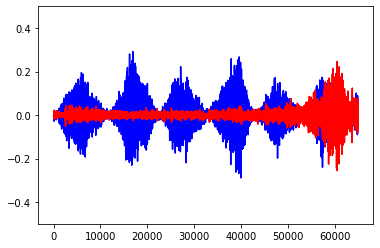

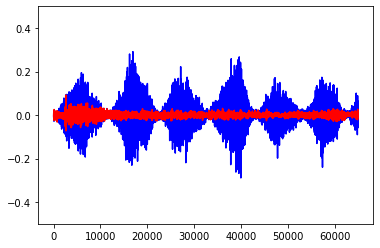

In [19]:
data_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/')
wav_pth = op.join(proj_pth, 'examples/esc50/mag_seg15_256/loss_test_output/audio')
output_pth = op.join(wav_pth, 'loss')
png_pth = op.join(wav_pth, 'png')
shape = ['square', 'time']
for filename in sorted(Path(data_pth).glob('*_res.wav')):
    #print(filename)
    origin_waveform, sr = torchaudio.load(filename, normalization=True)
    #print("Min: {}\nMax: {}\nMean: {}".format(origin_waveform.min(), origin_waveform.max(), origin_waveform.mean()))
    #plt.figure()
    #plt.plot(origin_waveform[0])
    file = op.basename(filename).split('.')[0].split('_origin')[0]
    for anyshape in shape:
        #print(file, anyshape)
        file_shape = file + '_' + anyshape
        #print(file_shape)
        error_list = []
        for output in tqdm(sorted(Path(wav_pth).glob(f'{file_shape}*.wav'))):
            #print(output)
            inpainted_waveform, sr = torchaudio.load(output, normalization=True)
            #print("Min: {}\nMax: {}\nMean: {}".format(inpainted_waveform.min(), inpainted_waveform.max(), inpainted_waveform.mean()))
            #plt.figure()
            #plt.plot(inpainted_waveform[0])
            #print(inpainted_waveform.shape, _, l)
            diff = torch.mean(abs(inpainted_waveform - origin_waveform))
            err = ((origin_waveform-inpainted_waveform).abs() / origin_waveform.abs()).median()
            err_value = diff.item()
            error_list.append(err_value)
            #print(diff, err)
            
            wave_pack = np.concatenate((origin_waveform, inpainted_waveform), axis=0)
            # print(wave_pack.shape)
            plt.figure()
            plt.ylim(-0.5, 0.5)
            plt.plot(wave_pack[0], 'b', wave_pack[1], 'r')
            png_name = op.basename(output).split('.')[0] + '.png'
            png_name = op.join(png_pth, png_name)
            plt.savefig(png_name)
    break

In [ ]:
'''
if op.isdir(output_pth) is False:
    os.mkdir(output_pth)
error_filename = op.join(output_pth, f'{file_shape}_mean-l1.txt')
with open(error_filename, 'w') as f:
    for index in error_list:
        f.write(str(index)+'\n')
'''